In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe

import warnings

import planetary_computer as pc
import rioxarray as rioxr

import gc # garbage collector

import dask
import dask_gateway
import dask.array as da

import lidar_sampling_functions as lsf

In [2]:
t_alpha = time.time()

## Import train/test sets

In [3]:
X_train = pd.read_csv(os.path.join(os.getcwd(),'create_train_test_sets','train_set.csv')).loc[:,'r':'avg_lidar']
y_train = pd.read_csv(os.path.join(os.getcwd(),'create_train_test_sets','train_set.csv')).loc[:,'iceplant'] 

In [4]:
# remove 2012 and 2014 since these do not have LIDAR data of their own.
X_train = X_train.loc[X_train.year != 2012]
X_train = X_train.loc[X_train.year != 2014]
X_train.year.unique()

array([2016, 2018, 2020])

In [6]:
y_train = y_train.iloc[X_train.index]

Int64Index([ 24005,  24006,  24007,  24008,  24009,  24010,  24011,  24012,
             24013,  24014,
            ...
            395612, 395613, 395614, 395615, 395616, 395617, 395618, 395619,
            395620, 395621],
           dtype='int64', length=263511)

In [7]:
mpe.iceplant_proportions(np.array(y_train))

no-iceplant:iceplant ratio     2.6 :1
          counts  percentage
iceplant                    
0         190655       72.35
1          72856       27.65



## Train model

In [8]:
from dask_ml.wrappers import ParallelPostFit

In [9]:
t0 = time.time()

rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, random_state = 42))
rfc.fit(X_train, y_train)

print('time to train: ', (time.time()-t0))

time to train:  26.112372636795044


In [10]:
del X_train, y_train
gc.collect()

24

# Select NAIP scene and LIDAR year

In [14]:
# gaviota_itemids = ['ca_m_3412039_nw_10_060_20200522',
# 'ca_m_3412039_nw_10_060_20180724_20190209',
# 'ca_m_3412039_nw_10_.6_20160616_20161004',
# 'ca_m_3412039_nw_10_1_20140603_20141030',
# 'ca_m_3412039_nw_10_1_20120518_20120730']

In [15]:
campus_itemids = ['ca_m_3411934_sw_11_060_20200521',
                  'ca_m_3411934_sw_11_060_20180722_20190209',
                  'ca_m_3411934_sw_11_.6_20160713_20161004']

In [66]:
# **************************************************************
# ********* SPECIFY ITEMID AND LIDAR YEAR TO MATCH HERE ********

itemid = campus_itemids[2] # NAIP scene over Conception Point
lidar_year = 2016
save_raster = True
filename = 'LIDAR+NAIP_campus_'+str(lidar_year)+'_predictions.tif'

# **************************************************************
# **************************************************************

# Open NAIP scene for classification

In [67]:
href = pc.sign(ipf.get_item_from_id(itemid).assets["image"].href)

# rioxarray of complete naip scene
naip_scene = rioxr.open_rasterio(rasterio.open(href))

# Prepare LIDAR data for sampling

In [68]:
# Create auxiliary LIDAR files to sample from
lidar_reader = rasterio.open(lsf.path_to_lidar(lidar_year))
lsf.save_min_max_rasters(lidar_reader, os.getcwd()+'/temp',lidar_year)
lsf.save_avg_rasters(lidar_reader, os.getcwd()+'/temp',lidar_year)

In [70]:
# Resample lidar layers to match NAIP scene resolution and extent

lidar_match = lsf.open_and_match(fp, naip_scene)

fp = os.path.join(os.getcwd(),'temp','lidar_mins_'+str(lidar_year)+'.tif')
mins_match = lsf.open_and_match(fp, naip_scene)

fp = os.path.join(os.getcwd(),'temp','lidar_maxs_'+str(lidar_year)+'.tif')
maxs_match = lsf.open_and_match(fp, naip_scene)

fp = os.path.join(os.getcwd(),'temp','lidar_avgs_'+str(lidar_year)+'.tif')
avg_match = lsf.open_and_match(fp, naip_scene)

In [71]:
# Assemble LIDAR layers into dataframe 

df_lidar = pd.DataFrame()
df_lidar['lidar'] = lidar_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['max_lidar'] = maxs_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['min_lidar'] = mins_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['min_max_diff'] = df_lidar.max_lidar - df_lidar.min_lidar
df_lidar['avg_lidar'] = avg_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])

In [72]:
# clear memory
del avg_match, mins_match, maxs_match, lidar_match
gc.collect()

659

In [73]:
# Delete auxiliary LIDAR rasters in temp folder
lidar_fps = []
for tag in ['maxs_', 'mins_', 'avgs_']:
    lidar_fps.append(os.path.join(os.getcwd(),
                                  'temp',
                                  'lidar_'+tag+ str(lidar_year)+'.tif'))
for fp in lidar_fps:
    os.remove(fp)

# Select points to be classified using NDVI threshold

In [74]:
# select pixel with vegetation
veg = ipf.features_over_aoi(ipf.get_item_from_id(itemid), 
                           naip_scene.to_numpy(), 
                           thresh=0.05)
veg

,r,g,b,nir,ndvi,year,month,day_in_year
1,50,50,66,57,0.065421,2016,7,195
2,46,47,58,52,0.061224,2016,7,195
4,44,46,58,52,0.083333,2016,7,195
5,46,47,58,56,0.098039,2016,7,195
6,81,81,77,114,0.169231,2016,7,195
...,...,...,...,...,...,...,...,...
128567088,29,40,56,36,0.107692,2016,7,195
128567543,34,47,64,39,0.068493,2016,7,195
128573373,46,70,67,51,0.051546,2016,7,195
128576369,53,71,77,61,0.070175,2016,7,195


# Sample and add LIDAR to vegetation pixels

In [75]:
# select same indices as vegetation
df_lidar_veg = df_lidar.iloc[veg.index]
df_lidar_veg

,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar
1,3,3,2,1,2.444444e+00
2,3,3,2,1,2.444444e+00
4,3,3,2,1,2.444444e+00
5,3,3,2,1,2.444444e+00
6,3,3,2,1,2.444444e+00
...,...,...,...,...,...
128567088,-32768,255,255,0,3.402823e+38
128567543,-32768,255,255,0,3.402823e+38
128573373,-32768,255,255,0,3.402823e+38
128576369,-32768,255,255,0,3.402823e+38


In [76]:
# add LIDAR features

# FEATURES MUST BE IN THIS ORDER TO MATCH THE MODEL:
# ['r', 'g', 'b', 'nir', 'ndvi', 
#  'year', 'month', 'day_in_year',
#  'lidar', 'max_lidar', 'min_lidar', 'min_max_diff', 'avg_lidar'])

scene_features = pd.concat([veg,df_lidar_veg],axis=1)
scene_features.head(4)

,r,g,b,nir,ndvi,year,month,day_in_year,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar
1,50,50,66,57,0.065421,2016,7,195,3,3,2,1,2.444444
2,46,47,58,52,0.061224,2016,7,195,3,3,2,1,2.444444
4,44,46,58,52,0.083333,2016,7,195,3,3,2,1,2.444444
5,46,47,58,56,0.098039,2016,7,195,3,3,2,1,2.444444


In [77]:
# clear memory
del veg, df_lidar, df_lidar_veg
gc.collect()

457

# Make dask data array of pixel values from NAIP scene raster

In [78]:
da_pixels = da.from_array(scene_features.to_numpy(), chunks=728802)
da_pixels

dask.array<array, shape=(29293669, 13), dtype=float64, chunksize=(728802, 13), chunktype=numpy.ndarray>

# Initialize Dask Cluster

In [79]:
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.scale(30)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.89ad88db67594394a4ca64c05ec244f1/status,


# Predict using dask

In [80]:
predictions = rfc.predict(da_pixels)
predictions

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


dask.array<_predict, shape=(29293669,), dtype=int64, chunksize=(728802,), chunktype=numpy.ndarray>

In [81]:
t0 = time.time()

preds = predictions.compute()
print('time to predict: ', time.time()-t0)

time to predict:  165.93159866333008


# Reassemble predictions into image

In [82]:
t0 = time.time()
# attach predictions to index of analyzed pixels
is_iceplant = pd.DataFrame(predictions, columns=['is_iceplant'], index=scene_features.index)

# select pixels classified as iceplant
is_iceplant = is_iceplant[is_iceplant.is_iceplant == 1]
print('select iceplant time: ', time.time()-t0)

select iceplant time:  100.50693988800049


In [83]:
t0 = time.time()
preds_image = ipf.indices_backto_image(naip_scene.shape[1], naip_scene.shape[2], is_iceplant.index)
print('indices to image time: ', time.time()-t0)

indices to image time:  0.21605205535888672


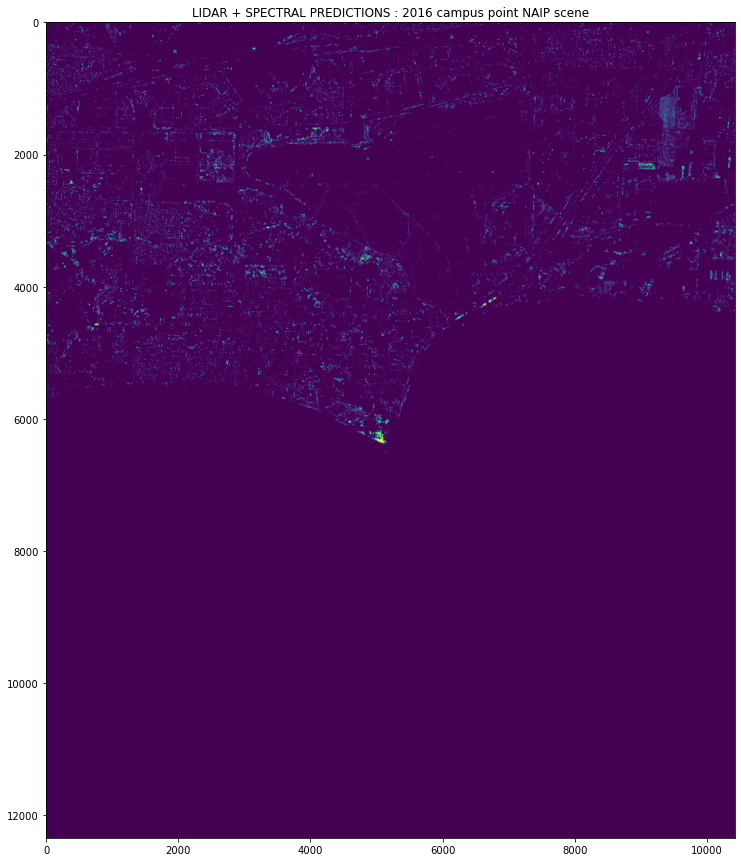

In [84]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("LIDAR + SPECTRAL PREDICTIONS : "+str(lidar_year)+ " campus point NAIP scene")
ax.imshow(preds_image)
plt.show()

In [85]:
# save if necessary

if save_raster == True:
    with rasterio.open(
        os.path.join(os.getcwd(),'temp',filename),  # file path
        'w',           # w = write
        driver='GTiff', # format
        height = preds_image.shape[0], 
        width = preds_image.shape[1],
        count = 1,  # number of raster bands in the dataset
        dtype = rasterio.uint8,
        crs = naip_scene.rio.crs,
        transform = naip_scene.rio.transform(),
    ) as dst:
        dst.write(preds_image.astype(rasterio.uint8), 1)

In [86]:
# clean memory
del naip_scene, scene_features
del preds_image, predictions
gc.collect()

3065

In [87]:
print('total time:', time.time() - t_alpha )

total time: 1037.3921012878418


distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1131)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 